In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_excel('/content/PROJECT DATASET.xlsx',names=['text','label'])
 

In [ ]:
df.head()

,text,label
0,రమేష్ రాజేష్ కి పక్కలో బెల్లంలా ఉన్నాడు,Idiom
1,రాజేష్ మాటలే కానీ చేతలు లేదు తెలిసిందే కదా మొర...,Literal
2,సెగలేనిదే పొగ రాదన్నట్లు రవి ఎవరు చెప్పకుండా ఏ...,Literal
3,మళ్లీ మళ్లీ రిపీట్ చేస్తూ చూస్తున్న వాళ్ళు ఎంత...,Literal
4,పొయ్యి కనీసం కొడుకులకు పని పాట లేదు కా బట్టి ద...,Literal


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

from transformers import XLMRobertaModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

<Axes: xlabel='label', ylabel='count'>

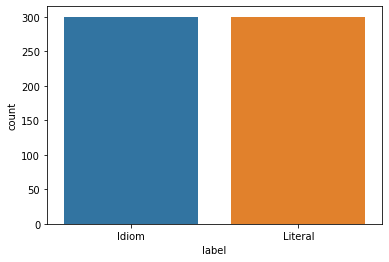

In [ ]:
sns.countplot(x=df.label)

In [ ]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
df["label_int"] = le.fit_transform(df['label'])
df.head()


,text,label,label_int
0,రమేష్ రాజేష్ కి పక్కలో బెల్లంలా ఉన్నాడు,Idiom,0
1,రాజేష్ మాటలే కానీ చేతలు లేదు తెలిసిందే కదా మొర...,Literal,1
2,సెగలేనిదే పొగ రాదన్నట్లు రవి ఎవరు చెప్పకుండా ఏ...,Literal,1
3,మళ్లీ మళ్లీ రిపీట్ చేస్తూ చూస్తున్న వాళ్ళు ఎంత...,Literal,1
4,పొయ్యి కనీసం కొడుకులకు పని పాట లేదు కా బట్టి ద...,Literal,1


<Axes: xlabel='label_int', ylabel='count'>

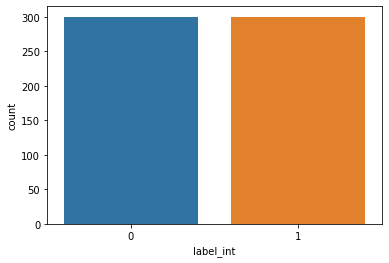

In [ ]:
sns.countplot(x=df.label_int)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)
#df_test_real = pd.read_csv('/content/tamil_news_test.csv')

In [ ]:
#df_test_real['label_int'] = df_test_real.Category.apply(sentiment)

In [ ]:
class_names = le.classes_

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
PRE_TRAINED_MODEL_NAME1 = 'xlm-roberta-base' 

In [ ]:
tokenizer1 = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
MAX_LEN = 100

In [ ]:
PRE_TRAINED_MODEL_NAME2 = 'bert-base-multilingual-cased' 
tokenizer2 = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME2)

In [ ]:
class TeluguDataset(Dataset):

  def __init__(self, text, label, tokenizer, max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True,
    )
    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long),
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TeluguDataset(
    text=df.text.to_numpy(),
    label=df.label_int.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader1 = create_data_loader(df_train, tokenizer1, MAX_LEN, BATCH_SIZE)
val_data_loader1 = create_data_loader(df_test, tokenizer1, MAX_LEN, BATCH_SIZE)

In [ ]:
train_data_loader2 = create_data_loader(df_train, tokenizer2, MAX_LEN, BATCH_SIZE)
val_data_loader2 = create_data_loader(df_test, tokenizer2, MAX_LEN, BATCH_SIZE)

In [ ]:
for i in train_data_loader1:
  break

In [ ]:
i

{'text': ['రమేష్ ని మార్చలేము వాడికి గాలిలో మెడలు కట్టడం అలవాటైపోయింది',
  'వీడి సహాయాన్ని అంది పుచ్చుకొని పైకెదిగాడు',
  'వాడు నన్ను పక్కదారి పట్టించాడు',
  'దేశాన్ని రామరాజ్యంలా మార్చడం ప్రజల చేతిలో ఉంది',
  'వారిద్దరు అచ్చంగా అచ్చు గుద్దినట్లు అమ్మ పోలికె',
  'జీవితములో కష్టాలను ఆటుపోటులతో పోల్చడము సర్వసాధారణము',
  'వీడు ఎవడురా పానకంలో పుడకలా',
  'నిజమైన బింబిసారుడు ని చూపించావు అన్న…',
  'ఆపదలు కలిగినప్పుడు భయపకుండా సమయ స్పూర్తి తో వాటిని జయించాలి',
  'ఈ సినిమా పెద్ద విజయం సాదించాలి అనీమనసుపూర్తిగా కోరుకుంటున్నాము',
  'పాపం వాడు అరచేతిలో ప్రాణాలుంచుకొని వచ్చాడు',
  'వాడు అపసోపాలు పడి వచ్చాడు',
  'పిల్లలతో వాడి జీవితం పంటపడింది',
  'ఈ పని సాధించాలంటే అడ్డంగా నరుక్కురావాలి',
  'అడవిలో పుట్టిన ఉసిరి, సముద్రంలో పుట్టిన ఉప్పు కలిసి నట్టు',
  'పసి కట్టడంలో పోలీసులకు మొదటి స్థానం',
  'బుద్ధిలేని వాడు ఏ పనిలోనైనా పానకంలో పడుకవలె అడ్డుపడతాడు',
  'వాడు అడకత్తెరలో పోక చెక్కలాగ చిక్కుకున్నాడు',
  'రవి కోరికలు ఆకాశానికి నిచ్చిన వేసినట్లు ఉంటాయి',
  'చిన్న అభిప్రాయ బేధం వల్ల పెళ్లి తునాతునకలైంది

In [ ]:
class TeluguClassifier1(nn.Module):

  def __init__(self, n_class):
    super(TeluguClassifier1, self).__init__()
    self.bert = XLMRobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME1, return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_class)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class TeluguClassifier2(nn.Module):

  def __init__(self, n_class):
    super(TeluguClassifier2, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME2, return_dict=False)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_class)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model1 = TeluguClassifier1(len(class_names))
model1 = model1.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model2 = TeluguClassifier2(len(class_names))
model2 = model2.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 3

optimizer1 = AdamW(model1.parameters(), lr=1e-5, correct_bias=False)
total_steps1 = len(train_data_loader1) * EPOCHS

scheduler1 = get_linear_schedule_with_warmup(
  optimizer1,
  num_warmup_steps=0,
  num_training_steps=total_steps1
)

loss_fn1 = nn.CrossEntropyLoss().to(device)

In [ ]:
optimizer2 = AdamW(model2.parameters(), lr=1e-5, correct_bias=False)
total_steps2 = len(train_data_loader2) * EPOCHS

scheduler2 = get_linear_schedule_with_warmup(
  optimizer2,
  num_warmup_steps=0,
  num_training_steps=total_steps2
)

loss_fn2 = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses) 

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses) 

In [ ]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f"Epoch {epoch + 1}/{EPOCHS}")
  print(f"-"*10)

  train_acc, train_loss = train_epoch(
      model1,
      train_data_loader1,
      loss_fn1,
      optimizer1,
      device,
      scheduler1,
      len(df_train)
  )

  print(f"Training loss {train_loss} accuracy {train_acc}")

  val_acc, val_loss = eval_model(
      model1, 
      val_data_loader1,
      loss_fn1,
      device,
      len(df_test)
  )

  print(f"Validation loss {val_loss} accuracy {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model1, "model1.pth")
    best_accuracy = val_acc

Epoch 1/3
----------
Training loss 0.687092657883962 accuracy 0.5125
Validation loss 0.5597424283623695 accuracy 0.725

Epoch 2/3
----------
Training loss 0.5597447554270426 accuracy 0.7
Validation loss 0.5769151523709297 accuracy 0.75

Epoch 3/3
----------
Training loss 0.47395495772361756 accuracy 0.7875
Validation loss 0.4083656519651413 accuracy 0.775

CPU times: user 19.6 s, sys: 5.71 s, total: 25.3 s
Wall time: 42.1 s


In [ ]:
model1.bert.train(True);

In [ ]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f"Epoch {epoch + 1}/{EPOCHS}")
  print(f"-"*10)

  train_acc, train_loss = train_epoch(
      model2,
      train_data_loader2,
      loss_fn2,
      optimizer2,
      device,
      scheduler2,
      len(df_train)
  )

  print(f"Training loss {train_loss} accuracy {train_acc}")

  val_acc, val_loss = eval_model(
      model2, 
      val_data_loader2,
      loss_fn2,
      device,
      len(df_test)
  )

  print(f"Validation loss {val_loss} accuracy {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model2, "model2.pth")
    best_accuracy = val_acc

Epoch 1/3
----------
Training loss 0.5432907402515411 accuracy 0.7083333333333334
Validation loss 0.4656152203679085 accuracy 0.75

Epoch 2/3
----------
Training loss 0.3058733721574148 accuracy 0.8729166666666667
Validation loss 0.3801010362803936 accuracy 0.8416666666666667

Epoch 3/3
----------
Training loss 0.1883884573976199 accuracy 0.9333333333333333
Validation loss 0.36017048731446266 accuracy 0.8583333333333333

CPU times: user 25.3 s, sys: 3.66 s, total: 29 s
Wall time: 32.8 s


In [ ]:
model2.bert.train(True);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  data_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      data_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return data_text, predictions, prediction_probs, real_values

In [ ]:
y_data_text1, y_pred1, y_pred_probs1, y_test1 = get_predictions(
  model1,
  val_data_loader1
)

In [ ]:
print(classification_report(y_test1, y_pred1, target_names=class_names))

              precision    recall  f1-score   support

       Idiom       0.71      0.92      0.80        60
     Literal       0.88      0.63      0.74        60

    accuracy                           0.78       120
   macro avg       0.80      0.77      0.77       120
weighted avg       0.80      0.78      0.77       120



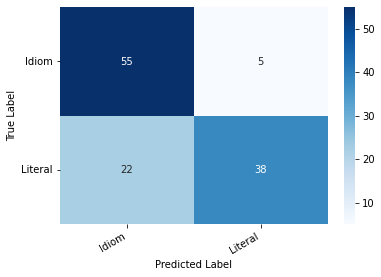

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test1, y_pred1)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_data_text2, y_pred2, y_pred_probs2, y_test2 = get_predictions(
  model2,
  val_data_loader2
)

In [ ]:
print(classification_report(y_test2, y_pred2, target_names=class_names))

              precision    recall  f1-score   support

       Idiom       0.86      0.85      0.86        60
     Literal       0.85      0.87      0.86        60

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



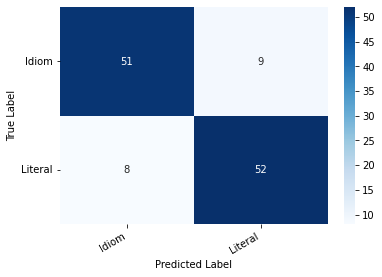

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test2, y_pred2)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
final_pred_prob=(y_pred_probs1+y_pred_probs2)/2

In [ ]:
pred=[]
for res in final_pred_prob:
  pred.append(np.argmax(res))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test1,pred)

0.8666666666666667

In [ ]:
print(classification_report(y_test1, pred, target_names=class_names))

              precision    recall  f1-score   support

       Idiom       0.85      0.88      0.87        60
     Literal       0.88      0.85      0.86        60

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



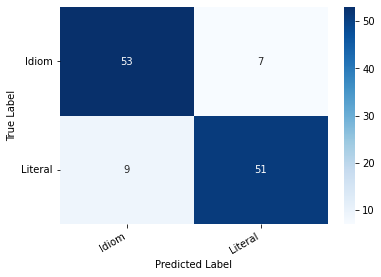

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test1,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)